In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import stats # for guinier fit
import pickle
import subprocess
import pandas as pd

import mdtraj as mdt

import os
import re
import datetime
import time

import copy

%matplotlib inline 
# use: inline/auto/notebook for the above magic command
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.patches import Rectangle

from IPython.display import Image

### Load all the needed data here:

In [2]:
dict_all = pickle.load(open("./dict_all_SI.dat", "rb"))
rg_kcl = pickle.load(open("./rg_short_KCl.dat", "rb"))

In [3]:
# the q range used for all the spectra below
q=np.linspace(0,0.3,31)

## Trajectories with position restraints on RNA and varying ionic conditions

__Here we initialize the dictionary with all the spectra:__

In [3]:
dict_all={}

__Here we load all the data and we fill the dictionary:  
NO NEED to do that, everything is already contained in the data loaded with pickle above.__

In [4]:
# path and name of the 4 systems
path='/scratch/mbernett/gtpase/analisi_saxs_waxs_review/short_trajs/'
names=['KCl','Mg0','MgHALF','MgALL']

In [5]:
# 1. CRYSOL
# see: https://www.embl-hamburg.de/biosaxs/manuals/crysol.html
for i in range(len(names)):
    allI_crys=[] 
    for j in range(0,2000):
        try:
            allI_crys.append(np.loadtxt(path+"%s/crysol/frame_0%05d00.int" % (names[i],j),skiprows=1)[:31,1])
        except OSError:
            pass
    if allI_crys: # if list is non-empty
        dict_all['s',names[i],'crysol']=np.array(allI_crys)
    else:
        pass

In [6]:
# CRYSOL: system KCl, scan over lm parameter (Maximum order of harmonics: min = 1, max = 50, default=15)
# NOTE: Stride 10 applied, not critical for this.
scan=[20,30,50]
for i in range(len(scan)):
    allI_crys=[] 
    for j in range(0,2000):
        try:
            allI_crys.append(np.loadtxt(path+"KCl/crysol/scan_lm/%s/frame_0%05d00.int" % (scan[i],j),
                                        skiprows=1)[:31,1])
        except OSError:
            pass
    if allI_crys: # if list is non-empty
        dict_all['s','KCl','crysol','lm_%s' % scan[i]]=np.array(allI_crys)
    else:
        pass

In [7]:
# Initialize dictionary for Rg* computed from the various scan of parameters
rgs_scan={}

In [8]:
# Guinier fit on the lm-parameter scan
lms=[20,30,50]
rgs_avg_scan=[]
for i in range(len(lms)):
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(np.average(dict_all['s','KCl','crysol','lm_%s' % lms[i]],axis=0)[2:7]/
              np.average(dict_all['s','KCl','crysol','lm_%s' % lms[i]],axis=0)[0]))
    rgs_avg_scan.append(np.sqrt(-3*slope))
rgs_scan['crysol','lms']=np.array(rgs_avg_scan)       

In [9]:
# load trajectory system KCl, JUST FOR COMPUTING Rg from the coordinates
path_traj='/scratch/mbernett/gtpase/keep_all_crystal/c_neutralize_with_MG/redo_with_opc_bigbox_differentMGconc/\
setup_KClONLY_2/production/'
solute=mdt.load(path_traj+"./traj_centered.xtc",top=path_traj+"./pdb_centered.pdb")

nframes=solute.n_frames
nframes

1001

In [10]:
rna_solute=solute.topology.select('resname A or resname U or resname C or resname G')

In [11]:
rg_kcl=mdt.compute_rg(solute.atom_slice(rna_solute))

In [12]:
fname = "rg_short_KCl.dat"
pickle.dump(rg_kcl,open(fname, "wb"))

In [13]:
# CRYSOL: system KCl, scan over dro parameter (Contrast of hydration shell (e/Å3), default 0.03)
# NOTE: Stride 10 applied, not critical for this.
scan=[0,0.03,0.06,0.1]
for i in range(len(scan)):
    allI_crys=[] 
    for j in range(0,2000):
        try:
            allI_crys.append(np.loadtxt(path+"KCl/crysol/scan_dro/%s/frame_0%05d00.int" % (scan[i],j),
                                        skiprows=1)[:31,1])
        except OSError:
            pass
    if allI_crys: # if list is non-empty
        dict_all['s','KCl','crysol','dro_%s' % scan[i]]=np.array(allI_crys)
    else:
        pass

In [14]:
# 2. CRYSOL 3 
# see: https://www.embl-hamburg.de/biosaxs/manuals/crysol3.html#exphydrogens

# The program is different from CRYSOL in the way how the hydration shell and its scattering are evaluated. 
# Instead of representation the shell as envelope function CRYSOL3 "incrusts" the surfaces and interiors 
# (were possible) of atomic structure with the dummy water beads like raisins in a muffin. This way of 
# the shell representation is more suitable for macromolecules with complex non-globular shapes and/or 
# with cavities. 

for i in range(len(names)):
    allI_crys=[] 
    for j in range(0,2000):
        try:
            allI_crys.append(np.loadtxt(path+"%s/crysol/crysol_30/scan_lm/20/frame_0%05d00.int" % (names[i],j),skiprows=1)[:31,1])
        except OSError:
            pass
    if allI_crys: # if list is non-empty
        dict_all['s',names[i],'crysol_30']=np.array(allI_crys)
    else:
        pass

In [15]:
# CRYSOL 3: system KCl, scan over lm parameter (Maximum order of harmonics: min = 1, max = 50, default=15)
scan=[20,30,50]
for i in range(len(scan)):
    allI_crys=[] 
    for j in range(0,2000):
        try:
            allI_crys.append(np.loadtxt(path+"KCl/crysol/crysol_30/scan_lm/%s/frame_0%05d00.int" % (scan[i],j),
                                        skiprows=1)[:31,1])
        except OSError:
            pass
    if allI_crys: # if list is non-empty
        dict_all['s','KCl','crysol_30','lm_%s' % scan[i]]=np.array(allI_crys)
    else:
        pass

In [16]:
# Guinier fit on the lm-parameter scan
lms=[20,30,50]
rgs_avg_scan=[]
for i in range(len(lms)):
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(np.average(dict_all['s','KCl','crysol_30','lm_%s' % lms[i]],axis=0)[2:7]/
              np.average(dict_all['s','KCl','crysol_30','lm_%s' % lms[i]],axis=0)[0]))
    rgs_avg_scan.append(np.sqrt(-3*slope))
rgs_scan['crysol_30','lms']=np.array(rgs_avg_scan)       

In [17]:
# 3. HUMMER
for i in range(len(names)):
    try:
        allI_Hum=np.loadtxt(path+'%s/hummer/sphere40_shell7_singles/postprocessor/1/intensity/dI.dat' % names[i])[:31,1]
        dict_all['s',names[i],'hum']=np.array(allI_Hum)
    except OSError:
        pass

In [18]:
# HUMMER with excluded volume
exVol=17800
for i in range(len(names)):
    try:
        di=np.loadtxt(path+'%s/hummer/sphere40_shell7_singles/postprocessor/1/intensity/dI.dat' % names[i])[:31,1]
        solvi=np.loadtxt(path+'%s/hummer/sphere40_shell7_singles/postprocessor/1/intensity/I_solv.dat' % names[i])[:31,1]
        allI_Hum=di+(4*exVol*solvi)
        dict_all['s',names[i],'hum_tot']=np.array(allI_Hum)
    except OSError:
        pass

In [19]:
# HUMMER: system KCl, scan over the radius and shell_width
# !!! LARGE SCAN
start=datetime.datetime.now()

radius=[4.0,4.5,5.0,5.2,5.4] # nm
shell=[.3,.4,.5,.6,.7,.8,.9,1.0,1.1,1.2,1.3,1.4,1.5] # nm

for i in range(len(radius)):
    for j in range(len(shell)):  
        dI_j=np.loadtxt(path+'KCl/hummer/sphere%s_shell%s/postprocessor/1/intensity/dI.dat' % \
                        (int(radius[i]*10),int(shell[j]*10)))[:31,1]
        # possibly add here solvent part
        dict_all['s','KCl','hum','R_%s' % radius[i],'sw_%s' % shell[j]]=dI_j
        
end=datetime.datetime.now()
tdelta=end-start
print("total seconds:",tdelta.total_seconds())

total seconds: 1.484473


In [20]:
# Guinier fit on the radius and shell_width parameters scan
for i in range(len(radius)):
    rgs_avg_scan=[]
    for j in range(len(shell)):
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            q[2:7]**2,
            np.log(dict_all['s','KCl','hum','R_%s' % radius[i],'sw_%s' % shell[j]][2:7]/
                  dict_all['s','KCl','hum','R_%s' % radius[i],'sw_%s' % shell[j]][0]))
        rgs_avg_scan.append(np.sqrt(-3*slope))
    rgs_scan['hum','R_%s'%radius[i]]=np.array(rgs_avg_scan)       

In [21]:
# HUMMER: system KCl, scan over the radius and shell_width
# !!! SHORT SCAN
start=datetime.datetime.now()

radius=[4.0,5.0,5.4] # nm
shell=[.7,1.0,1.5] # nm

for i in range(len(radius)):
    for j in range(len(shell)):
        singles=[]
        for k in range(1,1002):            
            dI_k=np.loadtxt(path+'KCl/hummer/scan_fbf/sphere%s_shell%s_singles/dI_frame%s.dat' % \
                            (int(radius[i]*10),int(shell[j]*10),k))[:31,1]
            singles.append(dI_k)
            # possibly add here solvent part
        dict_all['s','KCl','hum','R_%s' % radius[i],'sw_%s' % shell[j],'singles']=np.array(singles)
        
end=datetime.datetime.now()
tdelta=end-start
print("total seconds:",tdelta.total_seconds())

total seconds: 22.027225


In [22]:
# Guinier fit on the radius and shell_width parameters scan
for i in range(len(radius)):
    rgs_avg_scan=[]
    for j in range(len(shell)):
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            q[2:7]**2,
            np.log(dict_all['s','KCl','hum','R_%s' % radius[i],'sw_%s' % shell[j]][2:7]/
                  dict_all['s','KCl','hum','R_%s' % radius[i],'sw_%s' % shell[j]][0]))
        rgs_avg_scan.append(np.sqrt(-3*slope))
    rgs_scan['hum','R_%s'%radius[i]]=np.array(rgs_avg_scan)       

In [23]:
# 4. WAXSIS(envelope width=1)
for i in range(len(names)):
    try:
        allI_waxs=np.loadtxt(path+'%s/waxsis/waxscalc_l_final.xvg' % names[i],comments=['@','#','&'])[:31,1]
        dict_all['s',names[i],'waxsis']=np.array(allI_waxs)
    except OSError:
        pass

In [24]:
# WAXSIS: system KCl, scan over the envelope width parameter
envs=[0.7,1.0,1.5,2.0,2.5]
for i in range(len(envs)):
    try:
        allI_waxs=np.loadtxt(path+'KCl/waxsis/scan_d/%s/waxscalc_l_final.xvg' % envs[i],comments=['@','#','&'])[:31,1]
        dict_all['s','KCl','waxsis','env_%s'%envs[i]]=np.array(allI_waxs)
    except OSError:
        pass

In [25]:
# Guinier fit on the envelope width parameter scan
rgs_avg_scan=[]
for i in range(len(envs)):
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(dict_all['s','KCl','waxsis','env_%s'%envs[i]][2:7]/
              dict_all['s','KCl','waxsis','env_%s'%envs[i]][0]))
    rgs_avg_scan.append(np.sqrt(-3*slope))
rgs_scan['waxsis','envs']=np.array(rgs_avg_scan)       

In [26]:
# 5. PLUMED: both martini (ma) and all-atoms (aa)
for i in range(len(names)):
    try:
        allI_plum_ma=np.loadtxt(path+'%s/plumed/martini/colvar' % names[i])[:,2:33]
        dict_all['s',names[i],'plum_ma']=np.array(allI_plum_ma)
    except ValueError:
        pass
    except OSError:
        pass

for i in range(len(names)):
    try:
        allI_plum_aa=np.loadtxt(path+'%s/plumed/all_atom/colvar' % names[i])[:,1:32]
        dict_all['s',names[i],'plum_aa']=np.array(allI_plum_aa)
    except ValueError:
        pass
    except OSError:
        pass

In [27]:
fname = "dict_all_SI.dat"
pickle.dump(dict_all,open(fname, "wb"))

In [28]:
os.getcwd()

'/scratch/mbernett/gtpase/analisi_saxs_waxs_review'

In [29]:
%%bash
ls -lrth

total 27M
drwxr-xr-x. 4 mbernett sbp 4.0K Mar  2 14:50 long_trajs
-rw-r--r--. 1 mbernett sbp 2.7M Mar  9 16:21 prova_fake_rdf.dat
drwxr-xr-x. 6 mbernett sbp 4.0K Mar 17 09:34 short_trajs
-rw-r--r--. 1 mbernett sbp 2.1M Mar 22 08:58 scratch_review_saxs.ipynb
-rw-r--r--. 1 mbernett sbp  16K Mar 22 10:36 rg_long_KCl.dat
-rw-r--r--. 1 mbernett sbp  16K Mar 22 10:40 rg_long_MgKCl.dat
-rw-r--r--. 1 mbernett sbp 9.0M Mar 23 09:50 dict_all.dat
-rw-r--r--. 1 mbernett sbp 631K Apr  5 09:04 reviewFIG_all_progs_all_ionic_conditions_ALTERNATIVE.png
-rw-r--r--. 1 mbernett sbp 228K Apr  6 15:42 reviewFIG_PCA_all_systems.png
-rw-r--r--. 1 mbernett sbp 319K Apr  6 15:50 reviewFIG_matrix_all_methods_one_system.png
-rw-r--r--. 1 mbernett sbp 222K Apr  6 15:55 reviewFIG_matrix_all_systems.png
-rw-r--r--. 1 mbernett sbp  28K Apr  6 19:11 Gaussian_kernel_regression_check.ipynb
-rw-r--r--. 1 mbernett sbp 154K Apr  8 10:45 reviewFIG_kratkys_inset.png
-rw-r--r--. 1 mbernett sbp 166K Apr  8 10:58 reviewFIG_krat

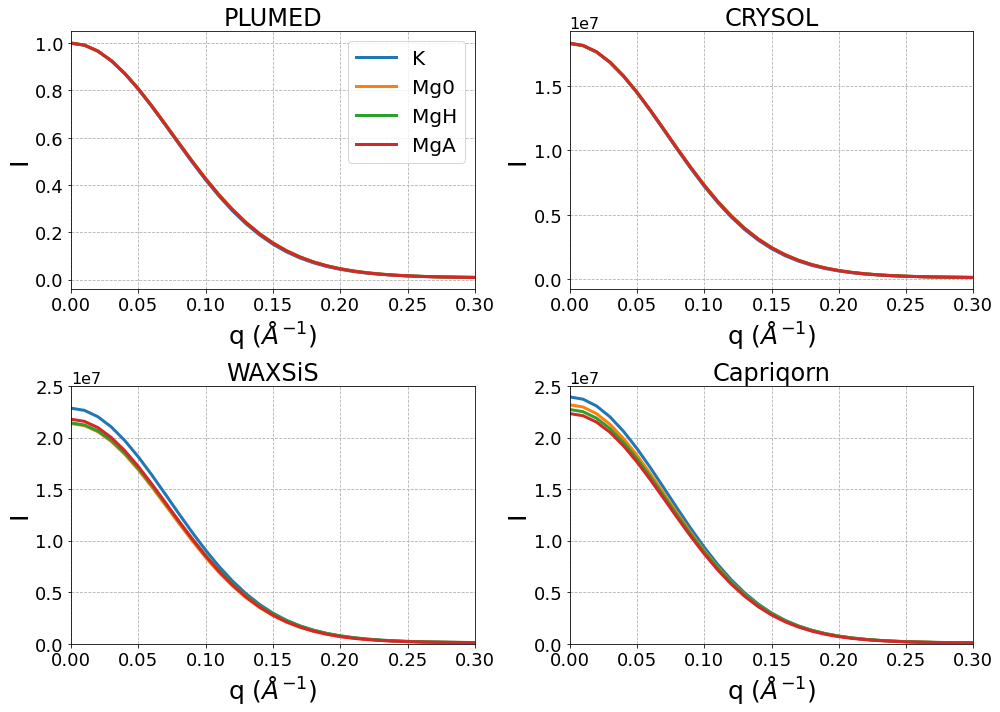

In [4]:
# plot all the methods for all the systems:
# here, for capriqorn, the contribution for the excluded volume is included (no difference with the above plot..)
fig, axs = plt.subplots(2,2, figsize=(14, 10))
axs = axs.ravel()

l_s='s' # long or short
titles=['PLUMED','CRYSOL','WAXSiS','Capriqorn']
prog=['plum_ma', 'crysol', 'waxsis', 'hum_tot'] # software used
names=['KCl','Mg0','MgHALF','MgALL']

# labels=['K$^+$, no Mg$^{2+}$',
#        'K$^+$, Mg$^{2+}$ crystal',
#        'K$^+$, Mg$^{2+}$ half',
#        'K$^+$, Mg$^{2+}$ all']
labels=['K','Mg0','MgH','MgA']

for i in range(len(prog)):
    for j in range(len(names)):
        try:
            if prog[i] not in ['waxsis','hum_tot']: # != 'waxs':
                axs[i].plot(q,np.average(dict_all[l_s,names[j],prog[i]],axis=0),
                            linewidth=3,label=labels[j])

                axs[i].set_xlim(0,0.3)
                #axs[i].set_ticklabel_format(style='sci', axis='y', scilimits=(0,0))

                axs[i].grid(axis='both', linestyle='--')
                if i==0:
                    axs[i].legend(fontsize=20) # 14.5 
                axs[i].set_xlabel("q ($\AA^{-1}$)", fontsize=25)
                axs[i].set_ylabel("I", fontsize=25)
                axs[i].tick_params(labelsize=18) # size=17
                axs[i].yaxis.get_offset_text().set_fontsize(16)
                #axs[i].set_xticklabels(fontsize=17)
                axs[i].set_title(titles[i], fontsize=24)
            else:
                axs[i].plot(q,dict_all[l_s,names[j],prog[i]],
                            linewidth=3,label=labels[j])

                axs[i].set_xlim(0,0.3)
                axs[i].set_ylim(0,2.5e7)
                #axs[i].set_ticklabel_format(style='sci', axis='y', scilimits=(0,0))

                axs[i].grid(axis='both', linestyle='--')
                if i==0:
                    axs[i].legend(fontsize=18) # 14.5 
                axs[i].set_xlabel("q ($\AA^{-1}$)",  fontsize=25)
                axs[i].set_ylabel("I", fontsize=25)
                axs[i].tick_params(labelsize=18)
                axs[i].yaxis.get_offset_text().set_fontsize(16) # plt.gca().yaxis ...
                #axs[i].set_yticklabels(fontsize=17)
                #axs[i].set_xticklabels(fontsize=17)
                axs[i].set_title(titles[i], fontsize=24)
        except KeyError:
            pass
            
fig.tight_layout()

#plt.subplots_adjust(right=1.4,top=4)
plt.show()
#plt.savefig('reviewFIG_all_progs_all_ionic_conditions.png', format='png', dpi=300, bbox_inches="tight")

## Kernel density to smooth noisy curves

In [7]:
path='./'
exp_mg=np.loadtxt(path+'gac_kcl_mgcl2.dat')
exp_k=np.loadtxt(path+'gac_kcl.dat')

__Extrapolating missing initial points in the exp spectra:__

In [8]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    exp_mg[:,0][:40]**2,
    np.log(exp_mg[:,1][:40]))

In [9]:
qs=np.linspace(0,0.269,270) # complete q exp

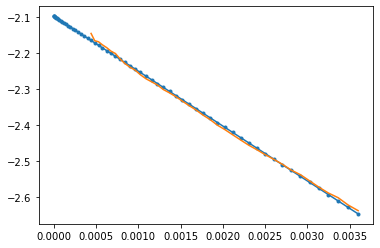

In [10]:
plt.plot(qs[:61]**2,intercept+slope*qs[:61]**2,marker='.')
plt.plot(exp_mg[:,0][:40]**2,np.log(exp_mg[:,1][:40]))
plt.show()

In [11]:
exp_mg_fx=np.zeros((len(qs),2))
exp_mg_fx[:,0]=qs
exp_mg_fx[:21,1]=np.exp(intercept+slope*qs[:21]**2) # first 3 values, np.exp !
exp_mg_fx[21:,1]=exp_mg[:,1]

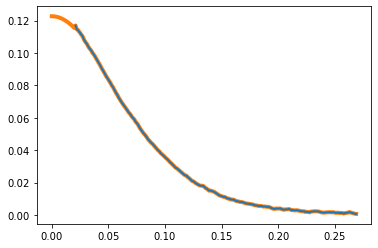

In [12]:
plt.plot(qs,exp_mg_fx[:,1],lw=4,c='C1')
plt.plot(exp_mg[:,0],exp_mg[:,1],lw=2)
plt.show()

In [13]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    exp_k[:,0][:40]**2,
    np.log(exp_k[:,1][:40]))

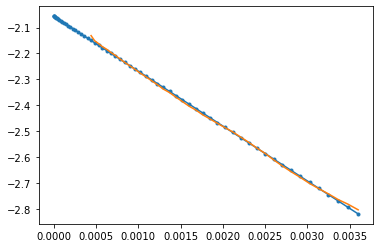

In [14]:
plt.plot(qs[:61]**2,intercept+slope*qs[:61]**2,marker='.')
plt.plot(exp_k[:,0][:40]**2,np.log(exp_k[:,1][:40]))
plt.show()

In [15]:
exp_k_fx=np.zeros((len(qs),2))
exp_k_fx[:,0]=qs
exp_k_fx[:21,1]=np.exp(intercept+slope*qs[:21]**2) # first 3 values, np.exp !
exp_k_fx[21:,1]=exp_k[:,1]

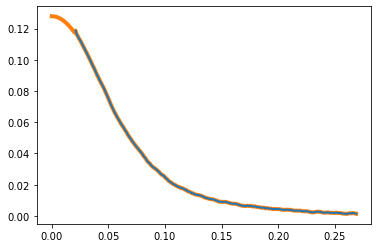

In [16]:
plt.plot(qs,exp_k_fx[:,1],lw=4,c='C1')
plt.plot(exp_k[:,0],exp_k[:,1],lw=2)
plt.show()

__Smoothing the experimental spectra through kernel regression:__

In [17]:
#from scipy.stats import multivariate_normal

'''Class for Gaussian Kernel Regression'''
class GKR:
    
    def __init__(self, x, y, b):
        self.x = np.array(x)
        self.y = np.array(y)
        self.b = b
    
    '''Implement the Gaussian Kernel'''
    def gaussian_kernel(self, z):
        return (1/np.sqrt(2*np.pi))*np.exp(-0.5*z**2)
    
    '''Calculate weights and return prediction'''
    def predict(self, XA):
        r=[]
        for X in XA:
            kernels = np.array([self.gaussian_kernel((np.linalg.norm(xi-X))/self.b) for xi in self.x])
            weights = np.array([len(self.x) * (kernel/np.sum(kernels)) for kernel in kernels])
            r.append(np.dot(weights.T, self.y)/len(self.x))
        return np.array(r)


__Just testing on a sample array of points__

In [18]:
x=np.linspace(0,10,1000)
y=np.sin(x)+np.random.normal(size=len(x))*0.1

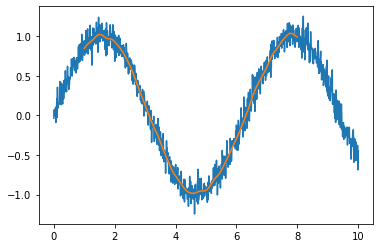

In [19]:
x1=np.linspace(1,8,300)
gkr=GKR(x,y,0.1)
y1=gkr.predict(x1)
plt.plot(x,y)
plt.plot(x1,y1)

plt.show()

In [20]:
q_pred=np.linspace(0,0.270,271) # complete q exp
#q_pred

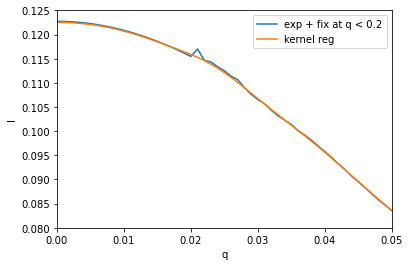

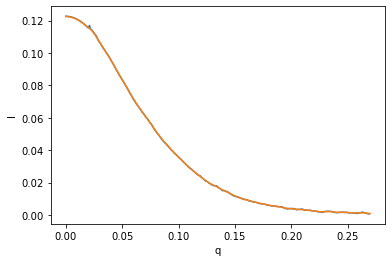

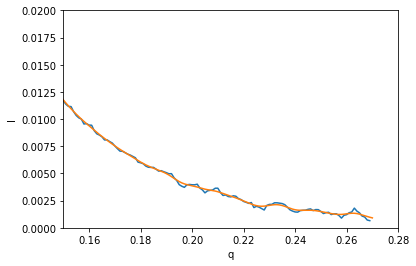

In [21]:
gkr=GKR(exp_mg_fx[:,0],exp_mg_fx[:,1],0.003)
y1=gkr.predict(q_pred)
plt.plot(exp_mg_fx[:,0],exp_mg_fx[:,1],label='exp + fix at q < 0.2')
plt.plot(q_pred,y1,label='kernel reg')
plt.xlim(0,0.05)
plt.ylim(0.08,0.125)
plt.ylabel('I')
plt.xlabel('q')
plt.legend()
plt.show()

plt.plot(exp_mg_fx[:,0],exp_mg_fx[:,1])
plt.plot(q_pred,y1)
plt.ylabel('I')
plt.xlabel('q')
plt.show()

plt.plot(exp_mg_fx[:,0],exp_mg_fx[:,1])
plt.plot(q_pred,y1)
plt.xlim(0.15,0.28)
plt.ylim(0.0,0.02)
plt.ylabel('I')
plt.xlabel('q')
plt.show()

In [22]:
gkr=GKR(exp_mg_fx[:,0],exp_mg_fx[:,1],0.003)
exp_mg_kr=gkr.predict(q_pred) # kernel regression

gkr=GKR(exp_k_fx[:,0],exp_k_fx[:,1],0.003)
exp_k_kr=gkr.predict(q_pred)

### Kratky plots (figure 2a and toc figure)

In [23]:
# KCl only: averages 2
averages4={}
# waxsis: env_
# hummer: R_ sw_
prog=['exp_k','exp_mg','plum_ma','plum_aa','crysol','crysol_30','hum','waxsis']
envs=[0.7,1.0,1.5]
radius=[4.0,5.0,5.4] # nm
shell=[.7,1.0,1.5] # nm
for i in range(len(prog)):
    if prog[i] in ['waxsis']:
        for j in range(len(envs)):
            averages4['%s_env_%s'%(prog[i],envs[j])]=dict_all['s','KCl',prog[i],'env_%s' % envs[j]]
    elif prog[i] in ['hum']:
        for k in range(len(radius)):
            for l in range(len(shell)):
                averages4['%s_R_%s_sw_%s'%(prog[i],radius[k],shell[l])]=\
                np.average(dict_all['s','KCl',prog[i],'R_%s' % radius[k],'sw_%s' % shell[l],'singles'],axis=0)
    elif prog[i] == 'exp_mg':
        averages4[prog[i]]=exp_mg_kr[::10]
    elif prog[i] == 'exp_k':
        averages4[prog[i]]=exp_k_kr[::10]       
    else:
        averages4[prog[i]]=np.average(dict_all['s','KCl',prog[i]],axis=0)
    

findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


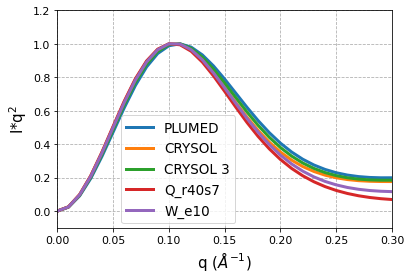

In [24]:
# plot Kratky
cs=['black','C1','darkcyan','deepskyblue','green']
lbl=['CRYSOL','PLUMED','W_e10','Q_r40s7','CRYSOL 3']

plt.plot(q,(averages4['plum_ma']*q**2)/np.max(averages4['plum_ma']*q**2),lw=3,label=lbl[1])
plt.plot(q,(averages4['crysol']*q**2)/np.max(averages4['crysol']*q**2),lw=3,label=lbl[0])
plt.plot(q,(averages4['crysol_30']*q**2)/np.max(averages4['crysol_30']*q**2),lw=3,label=lbl[4])
plt.plot(q,(averages4['hum_R_4.0_sw_0.7']*q**2)/np.max(averages4['hum_R_4.0_sw_0.7']*q**2),lw=3,label=lbl[3])
plt.plot(q,(averages4['waxsis_env_1.0']*q**2)/np.max(averages4['waxsis_env_1.0']*q**2),lw=3,label=lbl[2])

plt.xlim(0,0.3)

plt.grid(axis='both', linestyle='--')
plt.legend()

plt.xlabel("q ($\AA^{-1}$)", fontname='FreeSans', fontsize=15)
plt.ylabel("I*q$^2$", fontname='FreeSans', fontsize=15)
plt.yticks(fontname = 'FreeSans', fontsize=11)
plt.xticks(fontname = 'FreeSans', fontsize=11)

plt.legend(fontsize=13.5,loc=(0.19,0.02))
#plt.title("KCl",fontname = 'FreeSans', fontsize=20)
plt.ylim(-0.1,1.2)

plt.show()
#plt.savefig('reviewFIG_kratkys.png', format='png', dpi=300, bbox_inches="tight")

findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


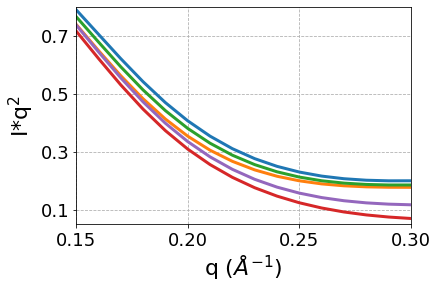

In [25]:
# plot Kratky
cs=['black','C1','darkcyan','deepskyblue']
lbl=['CRYSOL','PLUMED','WAXSiS','Capriqorn','CRYSOL 3']

plt.plot(q,(averages4['plum_ma']*q**2)/np.max(averages4['plum_ma']*q**2),lw=3,label=lbl[1])
plt.plot(q,(averages4['crysol']*q**2)/np.max(averages4['crysol']*q**2),lw=3,label=lbl[0])
plt.plot(q,(averages4['crysol_30']*q**2)/np.max(averages4['crysol_30']*q**2),lw=3,label=lbl[4])
plt.plot(q,(averages4['hum_R_4.0_sw_0.7']*q**2)/np.max(averages4['hum_R_4.0_sw_0.7']*q**2),lw=3,label=lbl[3])
plt.plot(q,(averages4['waxsis_env_1.0']*q**2)/np.max(averages4['waxsis_env_1.0']*q**2),lw=3,label=lbl[2])

plt.grid(axis='both', linestyle='--')

plt.xlabel("q ($\AA^{-1}$)", fontname='FreeSans', fontsize=22)
plt.ylabel("I*q$^2$", fontname='FreeSans', fontsize=22)
plt.yticks(np.linspace(0.1,0.7,4),fontname = 'FreeSans', fontsize=18)
plt.xticks(np.linspace(0.15,0.3,4),fontname = 'FreeSans', fontsize=18)

#plt.legend(fontsize=13.5,loc=(0.19,0.02))
#plt.title("KCl",fontname = 'FreeSans', fontsize=20)
plt.xlim(0.15,0.3)
plt.ylim(0.05,0.8)
#plt.axis('equal')
#plt.gca().set_aspect(1/plt.gca().get_data_ratio()) # !!!

plt.show()
#plt.savefig('reviewFIG_kratkys_inset.png', format='png', dpi=300, bbox_inches="tight")

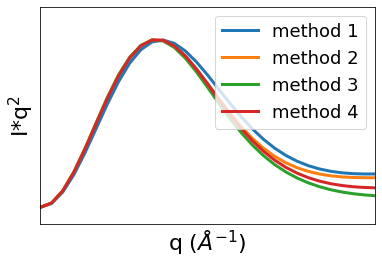

In [26]:
# plot Kratky
cs=['black','C1','darkcyan','deepskyblue','green']
lbl=['CRYSOL','PLUMED','W_e10','Q_r40s7','CRYSOL 3']

lbl=['method 1','method 2','method 3','method 4']

plt.plot(q,(averages4['plum_ma']*q**2)/np.max(averages4['plum_ma']*q**2),lw=3,label=lbl[0])
plt.plot(q,(averages4['crysol']*q**2)/np.max(averages4['crysol']*q**2),lw=3,label=lbl[1])
#plt.plot(q,(averages4['crysol_30']*q**2)/np.max(averages4['crysol_30']*q**2),lw=3,label=lbl[4])
plt.plot(q,(averages4['hum_R_4.0_sw_0.7']*q**2)/np.max(averages4['hum_R_4.0_sw_0.7']*q**2),lw=3,label=lbl[2])
plt.plot(q,(averages4['waxsis_env_1.0']*q**2)/np.max(averages4['waxsis_env_1.0']*q**2),lw=3,label=lbl[3])

plt.xlim(0,0.3)

plt.grid(axis='both', linestyle='--')
plt.legend()

plt.xlabel("q ($\AA^{-1}$)", fontname='FreeSans', fontsize=22)
plt.ylabel("I*q$^2$", fontname='FreeSans', fontsize=22)
plt.yticks([],fontname = 'FreeSans', fontsize=14)
plt.xticks([],fontname = 'FreeSans', fontsize=14)

plt.legend(fontsize=18) #,loc=(0.19,0.02))
#plt.title("KCl",fontname = 'FreeSans', fontsize=20)
plt.ylim(-0.1,1.2)

plt.show()
#plt.savefig('toc_1.png', format='png', dpi=300, bbox_inches="tight")

### Guinier fit (figure 2b)

__Sample procedure for Guinier fit with plot__

In [27]:
def linefitline(x):
    return intercept + slope * x # y = b + m*x

In [28]:
names=['KCl','Mg0','MgHALF','MgALL']
prog=['plum_ma', 'crysol', 'waxsis', 'hum']

In [29]:
spec=dict_all['s','MgALL','hum']
slope, intercept, r_value, p_value, std_err = stats.linregress(
    q[2:7]**2,
    np.log(spec[2:7]))

In [30]:
fitted_line = linefitline(q[2:7]**2)

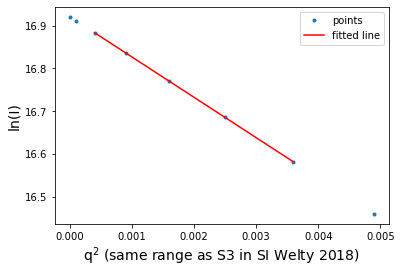

In [31]:
plt.plot(q[:8]**2,np.log(spec[:8]),
         '.',label='points')
plt.plot(q[2:7]**2,fitted_line, c='red',label='fitted line')

plt.xlabel('q$^2$ (same range as S3 in SI Welty 2018)',fontsize=14)
plt.ylabel('ln(I)',fontsize=14)

#plt.title('')
plt.legend()
plt.show()

In [32]:
print('Guinier fit Rg*:')
np.sqrt(-3*slope)

Guinier fit Rg*:


16.81249564103699

__Done on all the data:__

In [33]:
# KCl only: averages 2
averages2={}
# waxsis: env_
# hummer: R_ sw_
prog=['exp_k','exp_mg','plum_ma','plum_aa','crysol','crysol_30','hum','waxsis']
envs=[0.7,1.0,1.5]
radius=[4.0,5.0,5.4] # nm
shell=[.7,1.0,1.5] # nm
for i in range(len(prog)):
    if prog[i] in ['waxsis']:
        for j in range(len(envs)):
            averages2['%s_env_%s'%(prog[i],envs[j])]=dict_all['s','KCl',prog[i],'env_%s' % envs[j]][:28]
    elif prog[i] in ['hum']:
        for k in range(len(radius)):
            for l in range(len(shell)):
                averages2['%s_R_%s_sw_%s'%(prog[i],radius[k],shell[l])]=\
                np.average(dict_all['s','KCl',prog[i],'R_%s' % radius[k],'sw_%s' % shell[l],'singles'],axis=0)[:28]
    elif prog[i] == 'exp_mg':
        averages2[prog[i]]=exp_mg_kr[::10]
    elif prog[i] == 'exp_k':
        averages2[prog[i]]=exp_k_kr[::10]       
    else:
        averages2[prog[i]]=np.average(dict_all['s','KCl',prog[i]],axis=0)[:28]
    

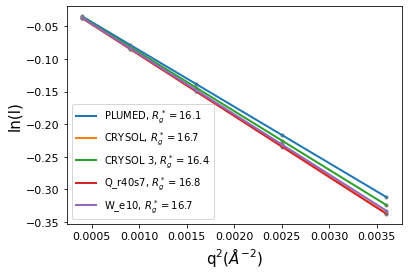

In [34]:
# plot Guinier
to_show=['plum_ma','crysol','crysol_30','hum_R_4.0_sw_0.7','waxsis_env_1.0']
labels=['PLUMED','CRYSOL','CRYSOL 3','Q_r40s7','W_e10']
col=['C1','C0','C2','C3','C4']
lw=[2,2,2,2,2]
for i in range(len(to_show)):
    spec=averages2[to_show[i]]/averages2[to_show[i]][0] # aligned at q=0
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(spec[2:7]))
    fitted_line = linefitline(q[2:7]**2)
    #
    plt.plot(q[2:7]**2,np.log(spec[2:7]),'.',color='gray') # ,label='points'
    #plt.plot(q[2:7]**2,fitted_line,label='fit on %s, $R_g^*=%.1f$'%(labels[i],np.sqrt(-3*slope)),
    plt.plot(q[2:7]**2,fitted_line,label='%s, $R_g^*=%.1f$'%(labels[i],np.sqrt(-3*slope)),
             lw=lw[i]) #,c=col[i])

plt.xlabel('q$^2 (\AA^{-2})$',fontsize=15)
plt.ylabel('ln(I)',fontsize=15)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
#plt.yscale('log')
plt.legend()

plt.show()
#plt.savefig('reviewFIG_guinier_fits.png', format='png', dpi=300, bbox_inches="tight")

In [35]:
# values of Rg*
to_show=['plum_ma','crysol','crysol_30','hum_R_4.0_sw_0.7','waxsis_env_1.0']

for i in range(len(to_show)):
    spec=averages2[to_show[i]]/averages2[to_show[i]][0] # aligned at q=0
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(spec[2:7]))
    print(to_show[i],'%.1f'%np.sqrt(-3*slope))

plum_ma 16.1
crysol 16.7
crysol_30 16.4
hum_R_4.0_sw_0.7 16.8
waxsis_env_1.0 16.7


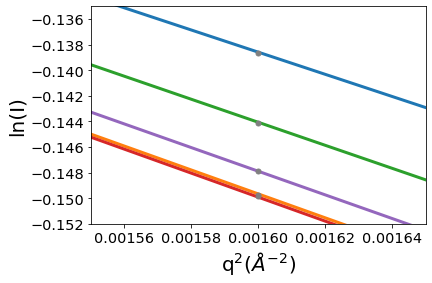

In [36]:
labels=['pm','c','c3','h_R40s7','w_e10']
lw=[3,3,3,3,3]
shifts=[]
for i in range(len(to_show)):
    spec=averages2[to_show[i]]/averages2[to_show[i]][0] # aligned at q=0
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        q[2:7]**2,
        np.log(spec[2:7]))
    fitted_line = linefitline(q[2:7]**2)
    #
    plt.plot(q[2:7]**2,fitted_line,label='fit of %s'%labels[i],lw=lw[i])#,c=col[i])
    plt.plot(q[2:7]**2,np.log(spec[2:7]),'.',color='gray',markersize=10) # ,label='points'

#plt.xlabel('q$^2$ (same range as S3 in SI Welty 2018)',fontsize=14)
plt.xlabel('q$^2 (\AA^{-2})$',fontsize=20)
plt.ylabel('ln(I)',fontsize=20)
plt.yticks(fontsize=14.5)
plt.xticks(fontsize=14.5)
#plt.yscale('log')
#plt.legend()
plt.xlim(0.00155,0.00165)
plt.ylim(-0.152,-0.135)
#plt.gca().set_aspect(1/plt.gca().get_data_ratio()) # !!!
plt.show()

#plt.savefig('reviewFIG_guinier_fits_inset.png', format='png', dpi=300, bbox_inches="tight")

### Distance matrices and PCA (figures 3a, 3b and 4)

__figure 3a__

In [37]:
# ALL METHODS, ALL SYSTEMS !!
averages3={}
# waxsis: env_
# hummer: R_ sw_
#prog=['plum_ma','plum_aa','crysol','crysol_30','hum','waxsis']
prog=['plum_ma','plum_aa','crysol','hum','waxsis']
prog=['plum_ma','crysol','waxsis','hum']
envs=[0.7,1.0,1.5]
radius=[4.0,5.0,5.4] # nm
shell=[.7,1.0,1.5] # nm

averages3['exp_k']=exp_k_kr[::10]
averages3['exp_mg']=exp_mg_kr[::10]

for i in range(len(prog)):
    for n in names:
        if prog[i] in ['waxsis','hum']:
            averages3[n,prog[i]]=dict_all['s',n,prog[i]][:28]
#            for j in range(len(envs)):
#                averages3[n,'%s_env_%s'%(prog[i],envs[j])]=dict_all['s',n,prog[i],'env_%s' % envs[j]]

#        elif prog[i] in ['hum']:
#            averages3[n,prog[i]]=np.average(dict_all['s',n,prog[i]],axis=0)
#            for k in range(len(radius)):
#                for l in range(len(shell)):
#                    averages3[n,'%s_R_%s_sw_%s'%(prog[i],radius[k],shell[l])]=\
#                    np.average(dict_all['s',n,prog[i],'R_%s' % radius[k],'sw_%s' % shell[l],'singles'],axis=0)     
        else:
            averages3[n,prog[i]]=np.average(dict_all['s',n,prog[i]],axis=0)[:28]
    

In [38]:
lista_avg3=list(averages3.keys())
#for i in range(len(lista_avg3)):
#    print(i,lista_avg3[i])

In [39]:
matx8=np.zeros((len(lista_avg3),len(lista_avg3)))

for i in range(len(lista_avg3)):
    v1=np.log(averages3[lista_avg3[i]]/averages3[lista_avg3[i]][0])
    for j in range(len(lista_avg3)):
        v2=np.log(averages3[lista_avg3[j]]/averages3[lista_avg3[j]][0])
        matx8[i,j]=np.sqrt(np.average((v1-v2)**2))


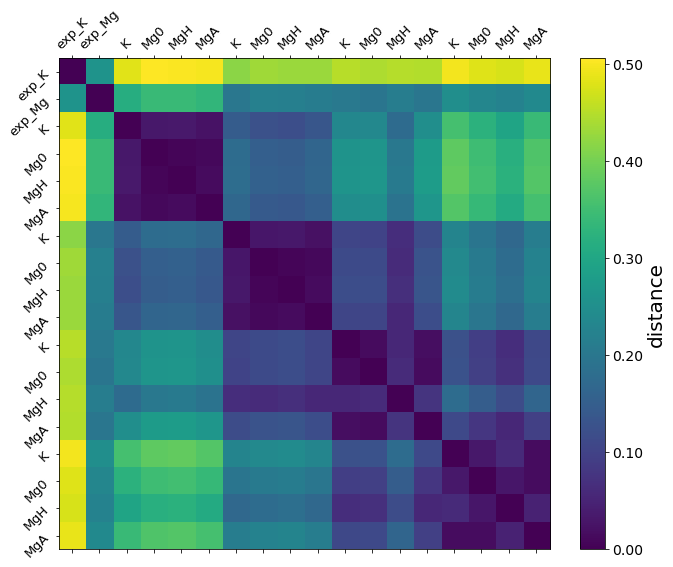

In [40]:
matfig=plt.figure(figsize=(11,11)) # !!!
plt.matshow(matx8,fignum=matfig.number) # !!!

cbar = plt.colorbar(orientation='vertical',shrink=0.8,format="%.2f",pad=0.05)
#cbar = plt.colorbar(orientation='vertical',boundaries=np.linspace(0,1,5),shrink=0.8,format="%.2f",pad=0.1)
#cbar.ax.ticks(np.linspace(0,1,9))
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('distance',fontsize=20)

#labels=[a[0] for a in list(averages3.keys()) if len(a)==2]
#labels=['exp_mg']+labels
#labels=['exp_k']+labels
labels=['exp_K','exp_Mg',
        'K','Mg0','MgH','MgA',
        'K','Mg0','MgH','MgA',
        'K','Mg0','MgH','MgA',
        'K','Mg0','MgH','MgA']

plt.xticks(ticks=range(len(labels)),labels=labels,rotation=45,fontsize=13)
plt.yticks(ticks=range(len(labels)),labels=labels,rotation=45,fontsize=13)
plt.ylim(17.5,-0.5)
plt.xlim(-0.5,17.5)

plt.show()
#plt.savefig('reviewFIG_matrix_all_systems.png', format='png', dpi=300, bbox_inches="tight")

__figure 3b__

In [41]:
lista_avg2=np.array(list(averages2.keys()))
#for i in range(len(lista_avg2)):
#    print(i,lista_avg2[i])

In [42]:
matx5=np.zeros((len(lista_avg2),len(lista_avg2)))

for i in range(len(lista_avg2)):
    v1=np.log(averages2[lista_avg2[i]]/averages2[lista_avg2[i]][0])
    for j in range(len(lista_avg2)):
        v2=np.log(averages2[lista_avg2[j]]/averages2[lista_avg2[j]][0])
        matx5[i,j]=np.sqrt(np.average((v1-v2)**2))


In [43]:
# KCl only: singles
singles={}
# waxsis: env_
# hummer: R_ sw_
prog=['exp_k','exp_mg','plum_ma','plum_aa','crysol','crysol_30','hum','waxsis']
envs=[0.7,1.0,1.5]
radius=[4.0,5.0,5.4] # nm
shell=[.7,1.0,1.5] # nm
for i in range(len(prog)):
    if prog[i] in ['waxsis']:
        for j in range(len(envs)):
            singles['%s_env_%s'%(prog[i],envs[j])]=dict_all['s','KCl',prog[i],'env_%s' % envs[j]][:28]
    elif prog[i] in ['hum']:
        for k in range(len(radius)):
            for l in range(len(shell)):
                singles['%s_R_%s_sw_%s'%(prog[i],radius[k],shell[l])]=\
                dict_all['s','KCl',prog[i],'R_%s' % radius[k],'sw_%s' % shell[l],'singles'][:28]
    elif prog[i] == 'exp_mg':
        singles[prog[i]]=exp_mg_kr[::10]
    elif prog[i] == 'exp_k':
        singles[prog[i]]=exp_k_kr[::10]      
    else:
        singles[prog[i]]=dict_all['s','KCl',prog[i]][:28]
    

In [44]:
lista_sing=np.array(list(singles.keys()))
#for i in range(len(lista_sing)):
#    print(i,lista_sing[i])

In [45]:
matx6=np.zeros((len(lista_sing),len(lista_sing)))

for i in range(len(lista_sing)):
    if lista_sing[i] in ['exp_mg','exp_k','waxsis_env_0.7','waxsis_env_1.0','waxsis_env_1.5']:
        for k in range(len(lista_sing)):
            matx6[i,k]=np.nan
    else:
        I0_avg1=np.average(singles[lista_sing[i]],axis=0)[0]
        v1=np.log(singles[lista_sing[i]].flatten()/I0_avg1)
        for j in range(len(lista_sing)):
            if lista_sing[j] in ['exp_mg','exp_k','waxsis_env_0.7','waxsis_env_1.0','waxsis_env_1.5']:
                matx6[i,j]=np.nan
            else:
                I0_avg2=np.average(singles[lista_sing[j]],axis=0)[0]
                v2=np.log(singles[lista_sing[j]].flatten()/I0_avg2)
                matx6[i,j]=np.std(v1-v2)


In [46]:
upper_half=np.triu(matx6,k=0)
lower_half=np.tril(matx5,k=0)

In [47]:
matx7=upper_half+lower_half

In [48]:
np.diagonal(matx7)

array([nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., nan, nan, nan])

In [49]:
np.fill_diagonal(matx7,0)

In [50]:
np.diagonal(matx7)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

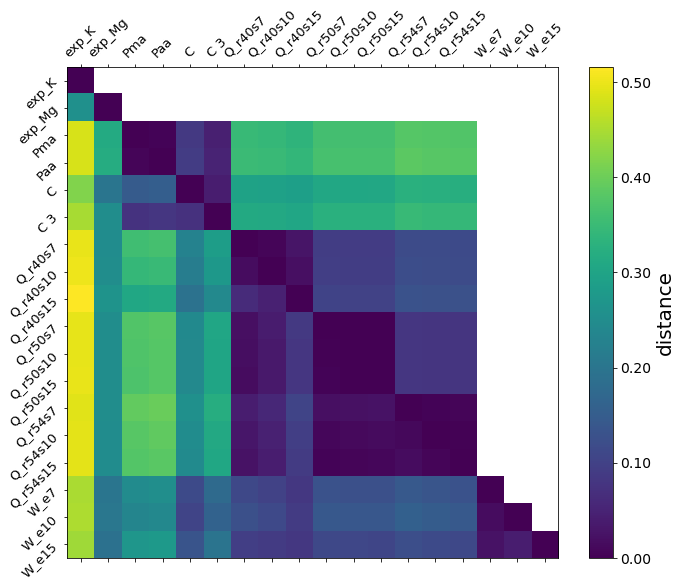

In [51]:
matfig=plt.figure(figsize=(11,11)) # !!!
plt.matshow(matx7,fignum=matfig.number) # !!!

cbar = plt.colorbar(orientation='vertical',shrink=0.8,format="%.2f",pad=0.05)
#cbar = plt.colorbar(orientation='vertical',boundaries=np.linspace(0,1,5),shrink=0.8,format="%.2f",pad=0.1)
#cbar.ax.ticks(np.linspace(0,1,9))
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('distance',fontsize=20)

labels=['exp_K','exp_Mg',
        'Pma','Paa',
        'C','C 3',
        'Q_r40s7','Q_r40s10','Q_r40s15',
        'Q_r50s7','Q_r50s10','Q_r50s15',
        'Q_r54s7','Q_r54s10','Q_r54s15',
        'W_e7','W_e10','W_e15']
plt.xticks(ticks=range(len(labels)),labels=labels,rotation=45,fontsize=13)
plt.yticks(ticks=range(len(labels)),labels=labels,rotation=45,fontsize=13)
plt.ylim(17.5,-0.5)

plt.show()
#plt.savefig('reviewFIG_matrix_all_methods_one_system.png', format='png', dpi=300, bbox_inches="tight")

__PCA__

In [52]:
aligned=[]
for i in range(len(lista_avg2)):
    aligned.append(np.log(averages2[lista_avg2[i]]/averages2[lista_avg2[i]][0]))
aligned=np.array(aligned)

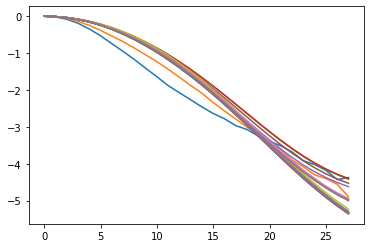

In [53]:
for i in range(len(aligned)):
    plt.plot(aligned[i])

In [55]:
from sklearn.decomposition import PCA

In [56]:
X=+aligned

In [57]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [58]:
X_pca = pca.transform(X)

In [59]:
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (18, 28)
transformed shape: (18, 2)


In [60]:
pca.explained_variance_ratio_

array([0.62105662, 0.37163388])

In [61]:
pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]

0.9926904995922011

In [62]:
labels=['exp_K','exp_Mg',
        'K,P','K,C','K,W','K,Q',
        'Mg0,P','Mg0,C','Mg0,W','Mg0,Q',
        'MgH,P','MgH,C','MgH,W','MgH,Q',
        'MgA,P','MgA,C','MgA,W','MgA,Q']

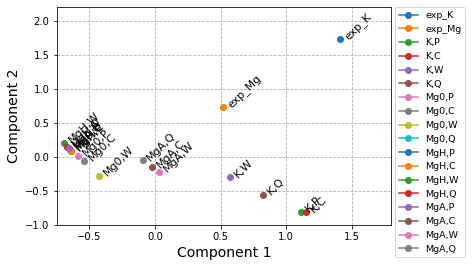

In [63]:
for i in range(len(X_pca)):
    plt.plot(X_pca[i][0],X_pca[i][1],marker='o',label=labels[i])
    plt.annotate(labels[i],(X_pca[i][0]+0.02,X_pca[i][1]),rotation=45,fontsize=11)

#plt.legend(loc=(1.05,0),ncol=2)
plt.xlabel('Component 1',fontsize=14)
plt.ylabel('Component 2',fontsize=14)

plt.xlim(-0.75,1.8)    # -0.75,1.8)
plt.ylim(-1,2.2)
#plt.xticks(fontsize)
plt.grid(ls='--')
#plt.gca().set_aspect('equal')
plt.legend(fontsize=9.5,loc=(1.01,-0.15))
plt.show()
#plt.savefig('reviewFIG_PCA_all_systems.png', format='png', dpi=300, bbox_inches="tight")

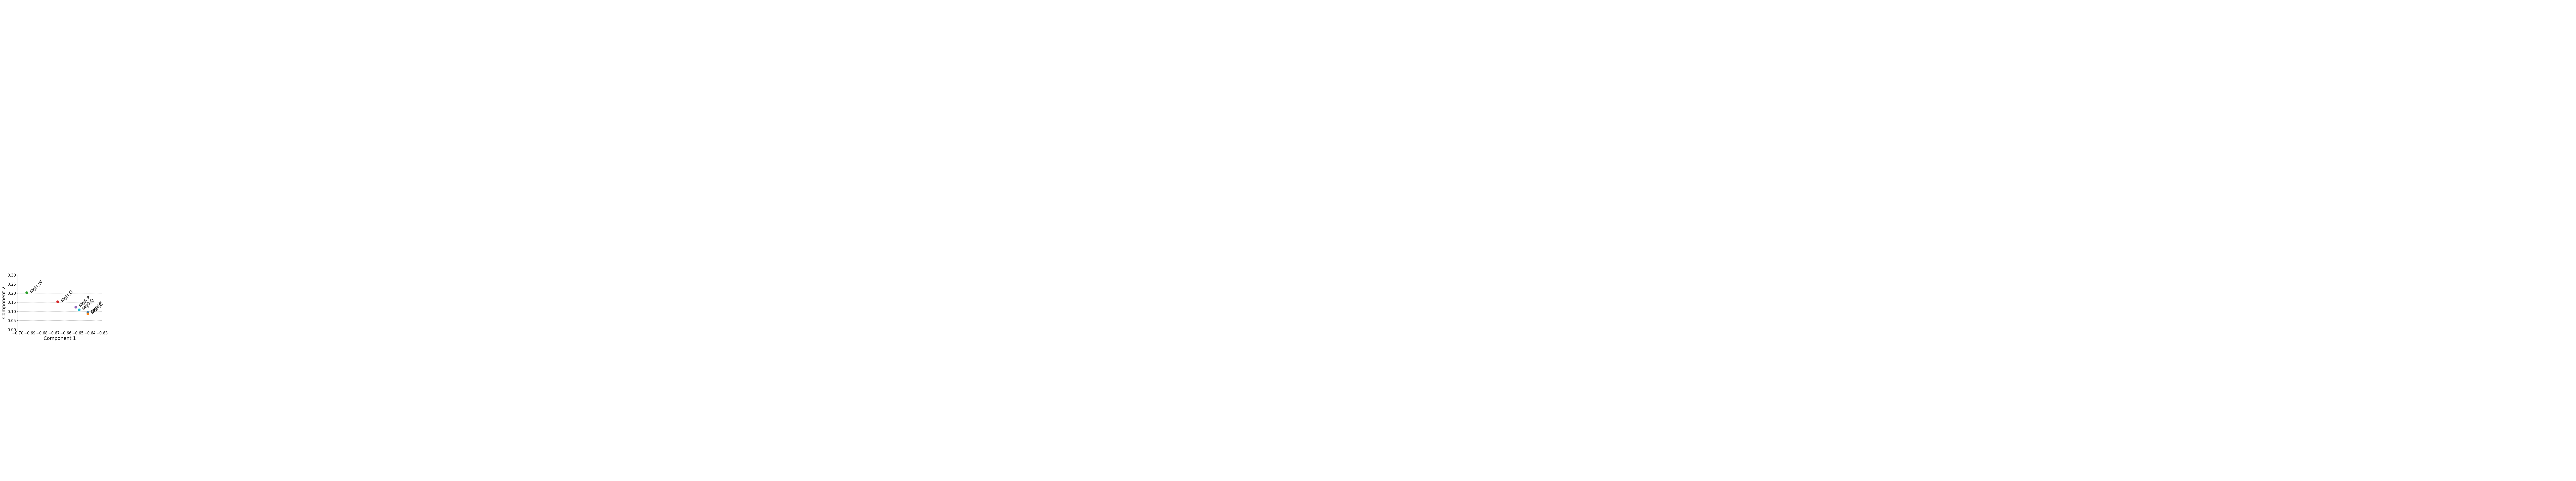

In [64]:
#plt.figure(figsize=(11,11))
#fig, ax = plt.subplots(figsize=(4, 4))
for i in range(len(X_pca)):
    plt.annotate(labels[i],(X_pca[i][0]+0.002,X_pca[i][1]),rotation=45,fontsize=18)
    plt.plot(X_pca[i][0],X_pca[i][1],marker='o',label=labels[i],markersize=10)
    #

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Component 1',fontsize=19)
plt.ylabel('Component 2',fontsize=19)

plt.xlim(-0.7,-0.63)
plt.ylim(-0,0.3)
plt.grid(ls='--')
#plt.legend(loc=(1.05,0),ncol=2)
#plt.gca().set_aspect('equal')
#plt.tight_layout()
plt.show()

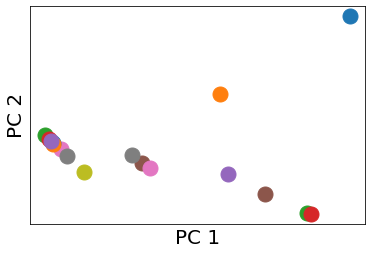

In [65]:
for i in range(len(X_pca)):
    plt.plot(X_pca[i][0],X_pca[i][1],marker='o',markersize=15) #,label=labels[i])
    #plt.annotate(labels[i],(X_pca[i][0]+0.02,X_pca[i][1]),rotation=45,fontsize=11)

#plt.legend(loc=(1.05,0),ncol=2)
plt.xlabel('PC 1',fontsize=20)
plt.ylabel('PC 2',fontsize=20)

#plt.xlim(-0.75,1.8)    # -0.75,1.8)
#plt.ylim(-1,2.2)
plt.xticks([]),plt.yticks([])
plt.grid(ls='--')
#plt.gca().set_aspect('equal')
#plt.legend(fontsize=9.5,loc=(1.01,-0.15))
#plt.show()
plt.savefig('toc_2.png', format='png', dpi=300, bbox_inches="tight")